In [2]:
import glob
all_text_files = glob.glob('data/names/*.txt')

In [5]:
import unicodedata
import string

In [24]:
fl = open('data/names/French.txt')

In [31]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [32]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
)

In [33]:
lines=fl.read().strip().split('\n')

In [34]:
unicode_to_ascii("Bélanger")

'Belanger'

In [35]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [36]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [40]:
category_languages = {}
all_categories = []

In [51]:
category_languages = {}
all_categories = []

def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_text_files:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    languages = readLines(filename)
    category_languages[category] = languages

no_of_languages = len(all_categories)
print('There are {} langauages'.format(no_of_languages))

There are 18 langauages


In [45]:
import torch

In [47]:
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [48]:
import torch.nn as nn
from torch.autograd import variable

In [117]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
       # print(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [118]:
torch.softmax

<function _VariableFunctions.softmax>

In [119]:
n_hidden = 128
rnn = RNN(n_letters,n_hidden,no_of_languages)

In [120]:
letter_to_tensor('D').shape

torch.Size([1, 57])

In [121]:
input = Variable(letter_to_tensor('D'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

input = Variable(line_to_tensor('Derrick'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

output.size = torch.Size([1, 18])
tensor([[-2.9058, -2.9607, -2.9749, -2.8952, -2.8759, -2.7628, -2.8220, -2.9496,
         -2.9238, -2.8164, -2.8958, -2.8174, -2.9618, -2.9309, -2.9553, -2.9903,
         -2.8094, -2.8195]], grad_fn=<LogSoftmaxBackward>)


/home/ganesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [122]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) 
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Italian', tensor(5))


In [123]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_languages[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Spanish / line = Abasolo
category = Spanish / line = Echeverria
category = Scottish / line = Milne
category = Scottish / line = Davidson
category = Chinese / line = Shen
category = Polish / line = Dubanowski
category = Russian / line = Ponomarev
category = Greek / line = Manos
category = German / line = Burgstaller
category = Korean / line = Ryoo


In [124]:
line

'Ryoo'

In [125]:
criterion = nn.NLLLoss()
 
learning_rate = 0.005 
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [126]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
   # print(loss.item())
    return output, loss.item()

In [127]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/home/ganesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 11s) 2.3197 Ibarra / Japanese ✗ (Spanish)
10000 10% (0m 22s) 1.9211 Le / Chinese ✗ (Vietnamese)
15000 15% (0m 33s) 1.2128 an / Vietnamese ✓
20000 20% (0m 44s) 0.5961 Weng / Chinese ✓
25000 25% (1m 0s) 0.1986 Ichihara / Japanese ✓
30000 30% (1m 12s) 3.9289 Haas / Arabic ✗ (German)
35000 35% (1m 21s) 0.7829 Seo / Korean ✓
40000 40% (1m 31s) 0.6553 Chalykh / Russian ✓
45000 45% (1m 40s) 0.0154 Nakasawa / Japanese ✓
50000 50% (1m 49s) 0.5015 Halabi / Arabic ✓
55000 55% (1m 58s) 0.3340 Araujo / Portuguese ✓
60000 60% (2m 8s) 2.9448 Tobias / Greek ✗ (French)
65000 65% (2m 18s) 1.6606 Miller / English ✗ (Scottish)
70000 70% (2m 30s) 0.4948 Shaw / Chinese ✓
75000 75% (2m 41s) 2.1968 Isa / Japanese ✗ (Arabic)
80000 80% (2m 50s) 0.5524 Youn / Korean ✓
85000 85% (3m 1s) 0.0102 O'Hagan / Irish ✓
90000 90% (3m 12s) 0.1139 Henderson / Scottish ✓
95000 95% (3m 23s) 0.0670 Najjar / Arabic ✓
100000 100% (3m 35s) 0.5017 Zhuan / Chinese ✓


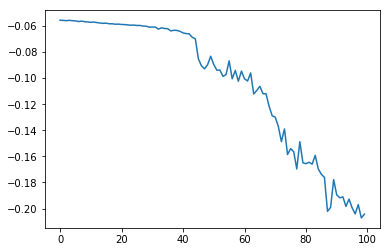

In [116]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

/home/ganesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


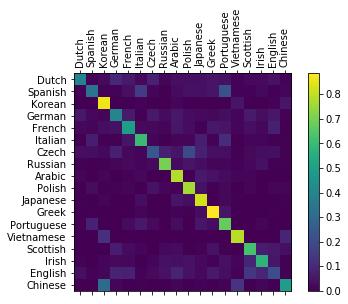

In [70]:
confusion = torch.zeros(no_of_languages, no_of_languages)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(no_of_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()